Homework 4:
---
For this homework we will be building various neural networks to classify handwritten digits.

### Question 1: Feed-Forward Neural Network to classify MNIST digits.

Train a neural network to classify MNIST digits. Remember we have to pick 3 different components to build a neural network: (1) Network Architecture (2) Loss Function and (3) Optimizer. For this assignment use the following:

Network Architecture:
* [28x28] input 
* -> Use a view to reshape to [784]
* -> Linear Layer [784, Num Hidden Units]
* -> Relu
* -> Output Linear Layer [NumHiddenUnits, 10]
* -> Log Softmax (`torch.nn.functional.log_softmax(output)`)

Loss: Please use the negative log likelihood loss function (nll_loss).
Optimizer: Please use SGD optimizer (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), but you can also experiment with Adam optimizer in 1.6.

1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

1.2 Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

```
for epoch in range(0, num_epochs):
  # Loop over the dataloader and get minibatches:
  for batch_idx, (data, target) in enumerate(train_dataloader):
    # TODO: Reset gradient on optimizer
    # TODO: Evaluate th emodel on data
    # TODO: Calculate loss using nll_loss
    # TODO: Evaluate gradient with respect to the loss function
    # TODO: Run a step of the optimizer.
    # TODO: Store the loss function for plotting every X batches.
```


1.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model ```trained_nn_model(sample)```. The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs `[.1, .2, .6, .1]` you would classify it as class 2.

1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?

1.6: Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers (for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.

1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them. 

### Question 2: Convolutional Neural Network to classify MNIST digits.

We will answer similar questions as above but using a convolutional neural network. Please start with this example network module: ```SimpleConvNetModel```

2.1: Create a Pytorch module to implement a version of this neural network as implemented above. Display the shape of the network using ` torchsummary.summary`.

2.2 Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.

2.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?

2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?

2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

Extra Credit 2.8: Use ```visualize_conv_model_weights``` to display convolutional network weights. Display for each convolutional layer. Please interpret these images and describe what they are showing.

In [18]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
# Load the MNIST dataset:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train_dataset = torchvision.datasets.MNIST(
    root='../../Data', train=True, download=True, transform=transform) 
mnist_test_dataset = torchvision.datasets.MNIST(
    root='../../Data', train=False, download=True, transform=transform)

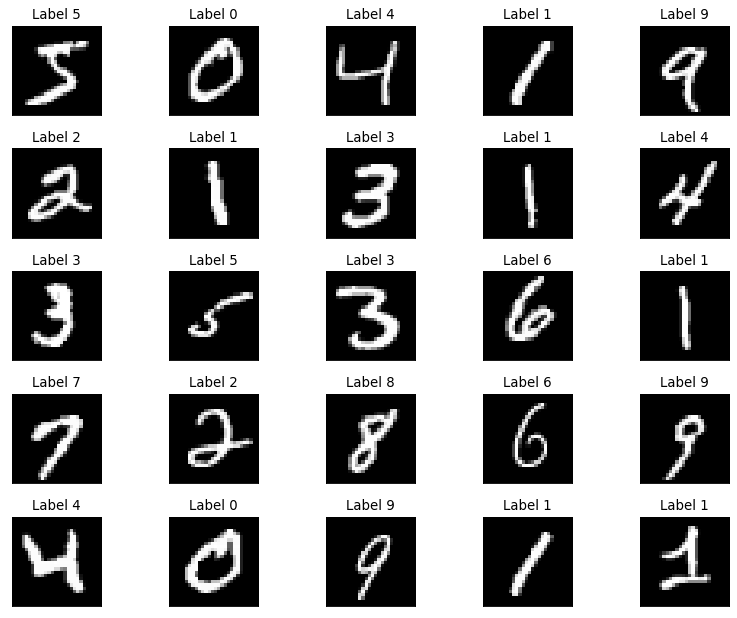

In [20]:
def image_grid(data, num_figs):
    """Function to display a grid of images
    Args:
      data: torchvision dataset
      num_figs: number of images to display
    """
    fig = figure(figsize=(10, 8), dpi=80)
    for i in range(num_figs):
        fig_i = int(math.sqrt(num_figs))
        plt.subplot(fig_i, fig_i, i+1)
        plt.tight_layout()
        image, label = data[i]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.title(f"Label {label}")
        plt.xticks([])
        plt.yticks([])
image_grid(mnist_train_dataset, 25)

In [21]:
# Let's set the random seed so we will get the same behavior each run.
random_seed = 42
torch.manual_seed(random_seed)

# Let's make sure to turn off GPU backend in case you happen to have GPU. The only
# reason we do this is not to have to worry about moving data and models on and
# off of the GPU for now. If you are training large models and have a GPU, then
# you will want to use it.
torch.backends.cudnn.enabled = False

In [22]:
# Put training and test data into data loaders allow batching of datasets.
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size_test, shuffle=True)
num_dimensions, num_classes, class_labels = 28**2, 10, [i for i in range(10)]

In [23]:
# I used this to save the model and optimizer states if needed
def saveModel(model, optmizer, path):
    progress = {
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
    }
    torch.save(progress, path)
    
def getModel(path, init_model, init_optimizer, learning_rate):
    progress = torch.load(path)
    model = init_model
    optimizer = init_optimizer(model.parameters(), lr=learning_rate)
    model.load_state_dict(progress["model_state"])
    optimizer.load_state_dict(progress["optim_state"])
    return model, optimizer

Question 1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

In [38]:
# Question 1.1
class SimpleNeuralNet(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, hidden_units)
        self.output_layer = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        z1 = self.linear(x)
        a1 = F.relu(z1)
        z2 = self.output_layer(a1)
        return F.log_softmax(z2, dim=1)

nn_model = SimpleNeuralNet(20)
summary(nn_model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  15,700
├─Linear: 1-2                            [-1, 10]                  210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  15,700
├─Linear: 1-2                            [-1, 10]                  210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

Question 1.2: Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

In [39]:
# Question 1.2
# Note: for SGD optimizer just put it in the parameter 
# Example: train(nn_model, epochs, train_loader, minibatch_steps, torch.optim.SGD(nn_model.parameters(), lr=1e-2), loss_function): 
def train(model, epochs, training_data, minibatch_steps, optimizer, loss_function): 
    losses = []
    for epochs in range(epochs):
        for batch_idx, (data, target) in enumerate(training_data):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % minibatch_steps == 0:
                losses.append(loss.item())
    return losses
optimizer = torch.optim.SGD(nn_model.parameters(), lr=1e-1) # Since we must use the SGD optimizer

Question 1.3: Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

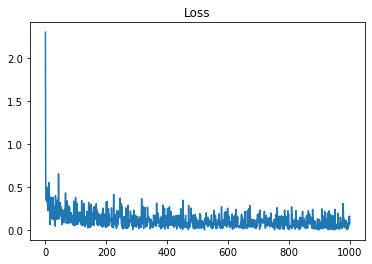

In [40]:
# Question 1.3   
loss = train(model=nn_model, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=optimizer, loss_function=F.nll_loss)
plt.plot(loss)
plt.title("Loss")
plt.show()

Question 1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model trained_nn_model(sample). The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs [.1, .2, .6, .1] you would classify it as class 2.

In [ ]:
# Question 1.4
def classifier(model, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model(data)
            predicted = torch.max(output.data, 1)[1] # Takes the index with the highest value
            total += target.size(0)                    
            correct += (predicted == target).sum().item() 
    return 100 * correct / total 

In [ ]:
print("Training Accuracy:", classifier(nn_model, train_loader))
print("Testing Accuracy:", classifier(nn_model, test_loader))

Training Accuracy: 96.945
Testing Accuracy: 95.2


Question 1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?  
Answer 1.5 <---> Look under the confusion matrix graph for the discussion for question 1.5

In [ ]:
# Question 1.5 - This function returns the graph of the confusion matrix 
def confusionMatrix(model, data_loader, class_labels):
    y_true, y_pred = [], []
    with torch.no_grad(): 
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model(data)
            y_pred.extend(torch.max(output.data, 1)[1].numpy())
            y_true.extend(target.numpy())

    # Displaying in a confusion Matrix
    matrix = confusion_matrix(y_true, y_pred, labels=class_labels)
    return ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_labels), [matrix[j][i] for i in range(len(class_labels)) for j in range(len(matrix[i])) if j != i]

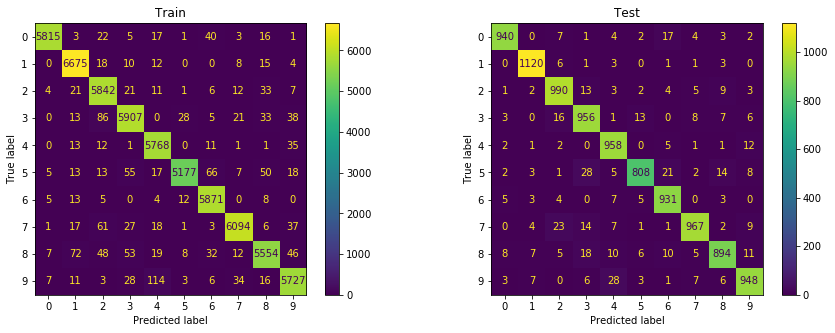

    List of incorrect Predictions
Train		|		Test
0: 29		|		0: 24
1: 176		|		1: 27
2: 268		|		2: 64
3: 200		|		3: 81
4: 212		|		4: 68
5: 54		|		5: 32
6: 169		|		6: 60
7: 98		|		7: 33
8: 178		|		8: 48
9: 186		|		9: 51


In [ ]:
# Displaying Train and Test confusion matrixes side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Train")
graph, graphList1 = confusionMatrix(nn_model, train_loader, class_labels)
graph.plot(ax=ax[0])
ax[1].set_title("Test")
graph, graphList2 = confusionMatrix(nn_model, test_loader, class_labels)
graph.plot(ax=ax[1])
plt.show()
print("    List of incorrect Predictions")
print("Train\t\t|\t\tTest")
for i in range(len(class_labels)):
    print(f"{i}: {sum(graphList1[i*(len(class_labels)-1):(i+1)*(len(class_labels)-1)])}\t\t|\t\t{i}: {sum(graphList2[i*(len(class_labels)-1):(i+1)*(len(class_labels)-1)])}")

In [ ]:
torch.bincount(mnist_train_dataset.targets, minlength=10)[1]
for i in range(0, 10):
    print(f"{i}: {torch.bincount(mnist_train_dataset.targets, minlength=10)[i].item()}")
# Seems like in the training dataset there are some numbers that have more images to train on than others

0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949


Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?  

Answer 1.5:   
    
Looking at the train and test confusion matrixes it looks like the numbers 2, 3 and 4 have been predicted the most when the prediction was incorrect.  

* When the model predicted the number 2 wrongly the most when the true label was 3 and 7. 

* Out of all the numbers the number 3 has been predicted the most times incorrectly. When the model predicted the number 3 wrongly the most when the true label was 2, 5, 7 and 8.  

* When the model predicted the number 4 wrongly the most when the true label was 8 an 9. 

To explain why this may have happened, we can list a few bullet points.  

* If you look in the cell above, the number of images per true label is listed. Clearly, there is not an equal number of images per number. This leads us to the assumption that the model may be training some numbers more than other numbers. Take for example the number 3, which has the third highest number of images in the training dataset. This makes it seem likely that the model is incorrectly predicting the number 3 more often than others because the equation of the model might somewhat favoring the prediction of the number 3 because that number had more images to train.

* Some of the images in the training data might have a true label of a number but the way the image is written is very close to the way another number may have been written. This will lead to the model confusing the number with another number because model's equation have been fitted in a way that the way the image of the number has been wrriten in such a way that it resembles closer to the other number.

* We have to take into account that the train and test accuracy is not 100% there is bound to be some errors into account.

Question 1.6: Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers 
(for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.  
Answer 1.6 <---> Look for discussion which is located right underneath experiment 4

Experiment 1:
Training Accuracy: 98.76333333333334
Testing Accuracy: 96.03


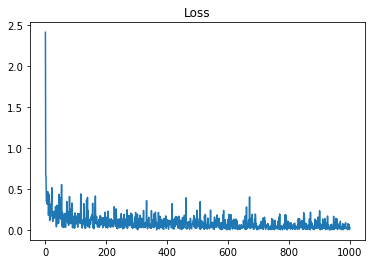

In [ ]:
# Experiment 1 - For this experiment we will try 30 hidden_units instead of 20
nn_1 = SimpleNeuralNet(30) # Since we have the hidden_units parameter, we can input the parameter for a different network shape
loss = train(model=nn_1, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.SGD(nn_1.parameters(), lr=1e-1), loss_function=F.nll_loss)
print("Experiment 1:")
print("Training Accuracy:", classifier(nn_1, train_loader))
print("Testing Accuracy:", classifier(nn_1, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 2:
Training Accuracy: 93.66166666666666
Testing Accuracy: 92.92


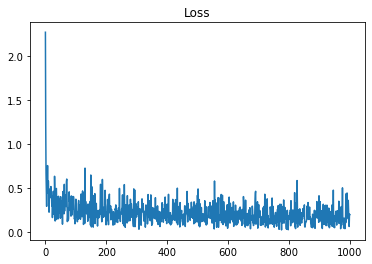

In [ ]:
# Experiment 2 - For this experiment we will try 15 hidden_units instead of 20
nn_2 = SimpleNeuralNet(15) # Since we have the hidden_units parameter, we can input the parameter for a different network shape
loss = train(model=nn_2, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.SGD(nn_2.parameters(), lr=1e-1), loss_function=F.nll_loss)
print("Experiment 2:")
print("Training Accuracy:", classifier(nn_2, train_loader))
print("Testing Accuracy:", classifier(nn_2, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 3:
Training Accuracy: 98.915
Testing Accuracy: 96.11


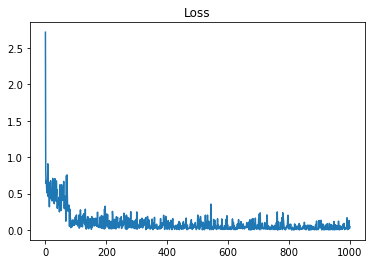

In [ ]:
# Experiment 3 - for this experiment we will use more hidden layers - Unfortunately to add more hidden layers we need to redefine the model
class nn_experiment(nn.Module):
    def __init__(self, hidden_units1, hidden_units2):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, hidden_units1)
        self.linear2 = nn.Linear(hidden_units1, hidden_units2)
        self.output_layer = nn.Linear(hidden_units2, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        z1 = self.linear(x)
        a1 = F.relu(z1)
        z2 = self.linear2(a1)
        a2 = F.relu(z2)
        z3 = self.output_layer(a2)
        return F.log_softmax(a2, dim=1)

nn_3 = nn_experiment(30, 15)
loss = train(model=nn_3, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.SGD(nn_3.parameters(), lr=1e-1), loss_function=F.nll_loss)
print("Experiment 3:")
print("Training Accuracy:", classifier(nn_3, train_loader))
print("Testing Accuracy:", classifier(nn_3, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 4:
Training Accuracy: 9.871666666666666
Testing Accuracy: 9.8


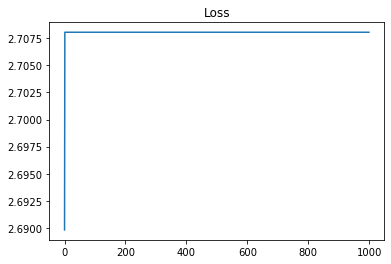

In [ ]:
# Experiment 4 - for this experiment we will use the same model as experiment 3 but use a different optimizer
nn_4 = nn_experiment(30, 15)
loss = train(model=nn_4, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(nn_4.parameters(), lr=1e-1), loss_function=F.nll_loss)
print("Experiment 4:")
print("Training Accuracy:", classifier(nn_4, train_loader))
print("Testing Accuracy:", classifier(nn_4, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 5:
Training Accuracy: 84.90833333333333
Testing Accuracy: 83.45


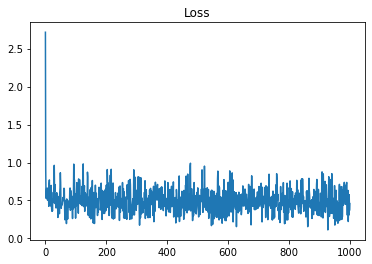

In [ ]:
# Experiment 4 - for this experiment we will use the same model as experiment 3 but use a different optimizer
nn_5 = nn_experiment(30, 15)
loss = train(model=nn_5, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(nn_5.parameters(), lr=1e-2), loss_function=F.nll_loss)
print("Experiment 5:")
print("Training Accuracy:", classifier(nn_5, train_loader))
print("Testing Accuracy:", classifier(nn_5, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 6:
Training Accuracy: 98.62333333333333
Testing Accuracy: 95.99


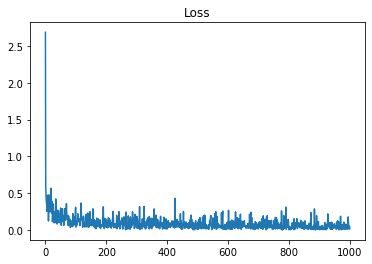

In [ ]:
# Experiment 4 - for this experiment we will use the same model as experiment 3 but use a different optimizer
nn_6 = nn_experiment(30, 15)
loss = train(model=nn_6, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(nn_6.parameters(), lr=1e-3), loss_function=F.nll_loss)
print("Experiment 6:")
print("Training Accuracy:", classifier(nn_6, train_loader))
print("Testing Accuracy:", classifier(nn_6, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.   

Answer 1.6:  

#### Note: In order to keep the experiments results fair I purposely kept the learning rate, number of epochs and optimizer the same.

Original:  
* Training Accuracy: 96.945  
* Testing Accuracy: 95.2  

Experiment 1: 
* Training Accuracy: 98.76333333333334  
* Testing Accuracy: 96.03  
* Increasing the number of hidden_units to 30 benefited the model and increased it's performance from the original model.
* This makes it seem like increasing the number of hidden_units may help improve the performance of the model.

Experiment 2:  
* Training Accuracy: 93.66166666666666    
* Testing Accuracy: 92.92   
* Decreasing the number of hidden_units to 15 did not benefit the model and instead decreased its performance from the original model.  
* This makes it seem like decreasing the number of hidden_units may hurt the performance of the model.

Experiment 3:  
* Training Accuracy: 98.915    
* Testing Accuracy: 96.11  
* Increasing the number of hidden_layers benefited the model and increased its performance to a level higher than all of the previous experiments.
* This makes it seem like increasing the number of hidden_units may help improve the performance of the model.

Experiment 4:  
* Training Accuracy: 9.871666666666666  
* Testing Accuracy: 9.8
* Changing the optimizer from SGD and Adam had terrible results when the learning_rate was kept the same. 
* I think each optimizer might prefer different learning rates and have different scores depending on the learning rate.
--------------------------------------------------------------------------------------------------------------------------------------------------
#### Note: I did experiments 5-6 with the Adam optimizer for my own personal curiosity.
#### Notice: The learning rate is different for experiment 5 and 6. Everything else is kept the same.

Experiment 5:  
* Training Accuracy: 84.90833333333333  
* Testing Accuracy: 83.45
* Changing the learning_rate to 1e-2 really benefited the performance of the model.
* The adam optimizer may prefer a lower learning rate thant he SGD optimizer.

Experiment 6:  
* Training Accuracy: 98.62333333333333
* Testing Accuracy: 95.99
* Changing the learning_rate to 1e-3 really benefitted the performance of the model as well.
* Seems like the learning_rate 1e-3 is much more beneficial for the Adam optimizer than the 1e-2 learning_rate.

#### EDIT: It's not in this notebook but I also tried the same model with lower learning_rates but it did not really show much performance improvements, I think 1e-3 may be the preferred learning_rate for this model when using the Adam optimizer.

Question 1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them.  
Answer 1.7 <---> Look under misclassification images to find discusion

Misclassification Found! True Value: 5 Predicted Value: 6


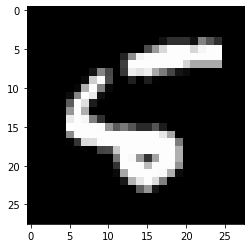

Misclassification Found! True Value: 4 Predicted Value: 6


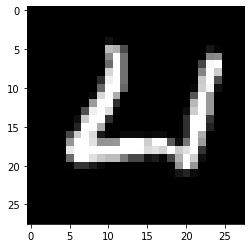

In [ ]:
# Question 1.7
def misclassification(model, dataset, num_misclassifications):
    # batch_size = 1 so we check 1 img at a time 
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False) 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader): 
            output = model(data)
            predicted = torch.max(output.data, 1)[1]
            image, label = dataset[batch_idx]
            if target.item() != predicted.item():
                print(f"Misclassification Found! True Value: {target.item()} Predicted Value: {predicted.item()}")
                plt.imshow(image.reshape(28, 28), cmap='gray')
                plt.show()
                num_misclassifications -= 1
                if num_misclassifications == 0:
                    break;  

misclassification(nn_model, mnist_test_dataset, num_misclassifications=2) # Shows n number of misclassifications in this case n=2

# Display these images and discuss why the model does not work well on them.
Answer 1.7:  
The above images show the n number of misclassified images. The function called set n=2 in the parameter just to keep it short and reduce confusion.  

* Looking at the first image the true label is 5, while the predicted label is 6. For this image it's easy to understand why the model may have mistaken it because the bottom line of the 5 is connected to the middle part of the 5 which makes it kind of look like a 6. I'm pretty sure a human would be able to classify the number as a 5 but they would complain that whoever wrote this number made it look strange. This strangeness confused the model and made it predict a 6 because normally the number 5 should not have been written in this way.

* Looking at the second image the true label is 4, while the predicted label is 6. Honestly, for this image I think even humans may confuse it because it looks like a really badly written " u ". For images like this it is very clear why the the model did not work properly because the equation probably didn't fit this type of image well to the number 4 because it most likely is very different from the other images of the number 4.

Question 2.1: Create a Pytorch module to implement a version of this neural network as implemented above. Display the shape of the network using torchsummary.summary

In [31]:
class SimpleConvNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dense_layer = nn.Linear(320, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)
        
        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)
        # View as 1-dimensional vector:
        a2 = a2.view(-1, 320) 
        
        # Dense linear layer
        z3_hidden = self.dense_layer(a2)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn_model = SimpleConvNetModel()
summary(cnn_model, (1, 28, 28))     

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Linear: 1-3                            [-1, 50]                  16,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Linear: 1-3                            [-1, 50]                  16,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

Question 2.2: Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.

In [ ]:
# Question 2.2
# Same function as in question 1.2. Adam optimizer is set in the parameter.
# --------------------------------------------------------------------------------- #
# def train(model, epochs, training_data, minibatch_steps, optimizer, loss_function): 
#     errors = []
#     for epochs in range(epochs):
#         for batch_idx, (data, target) in enumerate(training_data):
#             optimizer.zero_grad()
#             output = model(data)
#             loss = loss_function(output, target)
#             loss.backward()
#             optimizer.step()
#             if batch_idx % minibatch_steps == 0:
#                 errors.append(loss.item())
#     return errors
# Use below as parameter to set optimizer to Adam
# Note: i used lr=1e-3 because of previous NN experiments with adam showed this optimizer 
# converged easier with this learning rate 
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3) 

Question 2.3: Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

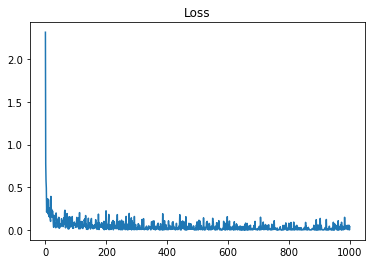

In [ ]:
# Question 2.3 - As stated in question 2.2 we will be using the we created function in question 1.2
loss = train(model=cnn_model, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=optimizer, loss_function=F.nll_loss)
plt.plot(loss)
plt.title("Loss")
plt.show()

Question 2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?  
Answer 2.4 <---> Look for discussion below performance printout

In [ ]:
# Question 2.4
# The below function is already defined and is reused for question 2.4 
# ------------------------------------------------------------------ # 
# def classifier(model, data_loader):
#     correct, total = 0, 0
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(data_loader):
#             output = model(data)
#             predicted = torch.max(output.data, 1)[1] # Takes the index with the highest value
#             total += target.size(0)                    
#             correct += (predicted == target).sum().item() 
#     return 100 * correct / total

In [ ]:
# Question 2.4 - Printing out model's performance
print("Training Accuracy:", classifier(cnn_model, train_loader))
print("Testing Accuracy:", classifier(cnn_model, test_loader))

Training Accuracy: 99.43333333333334
Testing Accuracy: 98.52


How does this compare to the performance of your non-convolutional neural network in question 1?  
    
Answer 2.4: The performance of the convolutional neural network is better than the performance of the non-convolutional neural network by quite a bit. The CNN model had a high accuracy of about 99.5% for training and a testing accuracy of 98.51%. The original NN, SimpleNeuralNet(30), had a training, testing accuracy of 96.945% and 95.2%. The best experiment for the Neural Network, NN_3(30, 15), had an training, testing accuracy of 98.915% and 96.11%. This shows that the CNN shows great promise because even without any experiments the model already beat all of the other neural networks in both training and testing accuracy.

Question 2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?  
Answer 2.5 <---> Look under confusion matrix graphs to find discusion

In [ ]:
# Commented function pasted here so it is easy to understand what is going on when we call it
# --------------------------------------  
# def confusionMatrix(model, data_loader, class_labels):
#     y_true, y_pred = [], []
#     with torch.no_grad(): 
#         for batch_idx, (data, target) in enumerate(data_loader):
#             output = model(data)
#             y_pred.extend(torch.max(output.data, 1)[1].numpy())
#             y_true.extend(target.numpy())
#
#     # Displaying in a confusion Matrix
#     matrix = confusion_matrix(y_true, y_pred, labels=class_labels)
#     return ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_labels), 
#     [matrix[j][i] for i in range(len(class_labels)) for j in range(len(matrix[i])) if j != i]

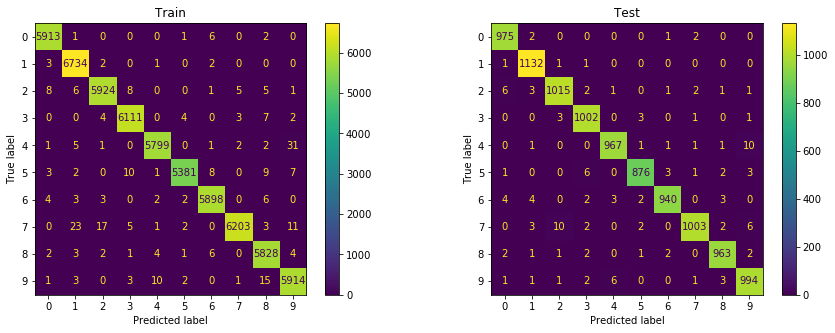

    List of incorrect Predictions
Train		|		Test
0: 22		|		0: 15
1: 46		|		1: 15
2: 29		|		2: 16
3: 27		|		3: 17
4: 19		|		4: 10
5: 12		|		5: 9
6: 24		|		6: 8
7: 11		|		7: 8
8: 49		|		8: 12
9: 56		|		9: 23


In [ ]:
# Question 2.5 - Displaying Train and Test confusion matrixes side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Train")
graph, graphList1 = confusionMatrix(cnn_model, train_loader, class_labels)
graph.plot(ax=ax[0])
ax[1].set_title("Test")
graph, graphList2 = confusionMatrix(cnn_model, test_loader, class_labels)
graph.plot(ax=ax[1])
plt.show()
print("    List of incorrect Predictions")
print("Train\t\t|\t\tTest")
for i in range(len(class_labels)):
    print(f"{i}: {sum(graphList1[i*(len(class_labels)-1):(i+1)*(len(class_labels)-1)])}\t\t|\t\t{i}: {sum(graphList2[i*(len(class_labels)-1):(i+1)*(len(class_labels)-1)])}")

Question 2.5: Which digits are mistaken for each other? How does this differ from 1.5?  

Answer 2.5:  

Looking at the train and test confusion matrixes it looks like the numbers 2, 3, 9 have been predicted the most when the prediction was incorrect.     
    
* When the model predicted the number 2 wrongly the most when the true label was 3, 7. 

* When the model predicted the number 3 wrongly the most when the true label was 2, 5 and 7. 

* Out of all the numbers the number 9 has been predicted the most times incorrectly. When the model predicted the number 3 wrongly the most when the true label was usually either 4 or 7.

The CNN model did not differ too much from the NN model because in both confusion matrixes the numbers 2, 3 have been common in misclassification. In fact, just like the NN model, the CNN model similarly predicted the number 2 and 3 wrongly for the same true labels most of the time.  

However, the difference between the CNN model and the NN model is that the CNN model predicted the number 9 incorrectly, which was not the case with the NN model which predicted the number 4 incorrectly instead.  

This is difference is expected because the the CNN vs NN models create their own equations for predicting the number and due to the differences in eachothers equations they may have different incorrect predictions.

Question 2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.  
Answer 2.6 <---> Look under discussion under experiment 4 to find discusion

Experiment 1:
Training Accuracy: 99.4
Testing Accuracy: 98.68


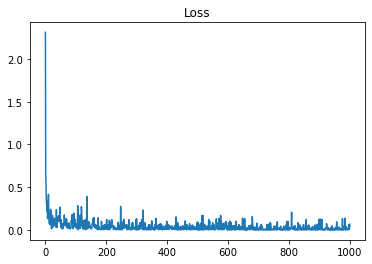

In [ ]:
# Experiment 1 - We will experiment making the kernel_size=6 instead of 5
class CNN_1(nn.Module):
    def __init__(self, kernel_size=[6, 6], stride_size=[1, 1], linear_size=180):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride_size = stride_size
        self.linear_size = linear_size
        self.conv1 = nn.Conv2d(1, 10, kernel_size=kernel_size[0], stride=stride_size[0])
        self.conv2 = nn.Conv2d(10, 20, kernel_size=kernel_size[1], stride=stride_size[1])
        self.dense_layer = nn.Linear(linear_size, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)
        
        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)
        # View as 1-dimensional vector:
        a2 = a2.view(-1, self.linear_size) 
        
        # Dense linear layer
        z3_hidden = self.dense_layer(a2)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn_1 = CNN_1() # default is kernel size = 6, stride = 1, linear_size = 180 <-- this differntiates from
loss = train(model=cnn_1, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(cnn_1.parameters(), lr=1e-3), loss_function=F.nll_loss)
print("Experiment 1:")
print("Training Accuracy:", classifier(cnn_1, train_loader))
print("Testing Accuracy:", classifier(cnn_1, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Experiment 2:
Training Accuracy: 98.78
Testing Accuracy: 97.4


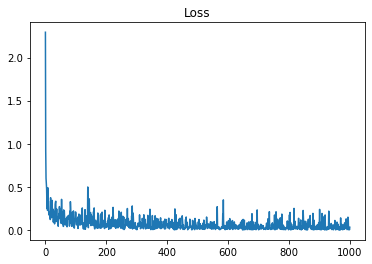

In [ ]:
# Experiment 2 - We will experiment by making the stride=2
cnn_2 = CNN_1(stride_size=[1, 2], linear_size=20) # reuse CNN_1() model by adjusting the parameters of the model to test different strides
loss = train(model=cnn_2, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(cnn_2.parameters(), lr=1e-3), loss_function=F.nll_loss)
print("Experiment 2:")
print("Training Accuracy:", classifier(cnn_2, train_loader))
print("Testing Accuracy:", classifier(cnn_2, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show()

Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.  

Answer 2.6:  

#### Note: Epochs and learning_rate is the same for all the experiments

Original: 
* Training Accuracy: 99.43333333333334
* Testing Accuracy: 98.52

Experiment 1: 
* Training Accuracy: 99.4
* Testing Accuracy: 98.68
* Using a larger kernel size may improve the test accuracy, even if only slightly. In this case using the 
larger kernel size of 6, over 5 helped increase the test accuracy. 
* Using a larger kernel may decrease training accuracy because in this experiment the accuracy was slightly lower than the original accuracy.

Experiment 2:
* Training Accuracy: 98.78
* Testing Accuracy: 97.4  
* Using a higher stride unfortunately lead to a decrease in performance for both training and testing accuracy.

Seems like a larger kernel size may lead to performance increases while a larger stride may not give a performance increase. Also do note that since the performance is so similar, the results may differ if ran again because the accuracy will change.

Question 2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

Experiment 3:
Training Accuracy: 99.11
Testing Accuracy: 98.45


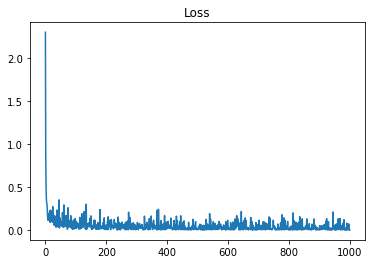

In [ ]:
class CNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=5)
        self.dense_layer = nn.Linear(360, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
    
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 1)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)

        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)   
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)

        # third convolutional layer
        z3 = self.conv2(a2)
        # Apply max pooling to convolution.
        z3_pooled = F.max_pool2d(z3, 2) 
        # Apply ReLu to pooled convolution
        a3 = F.relu(z3)

        # View as 1-dimensional vector:
        a3 = a3.view(-1, 360) 

        # Dense linear layer
        z4_hidden = self.dense_layer(a3)
        # Apply ReLu to linear layer.
        a4 = F.relu(z4_hidden)
        # Run dropout in training to help prevent overfitting
        a4_dropout = F.dropout(a4, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a4_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn_3 = CNN_3()
loss = train(model=cnn_3, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(cnn_3.parameters(), lr=1e-3), loss_function=F.nll_loss)
print("Experiment 3:")
print("Training Accuracy:", classifier(cnn_3, train_loader))
print("Testing Accuracy:", classifier(cnn_3, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show() 

Experiment 4:
Training Accuracy: 98.935
Testing Accuracy: 98.35


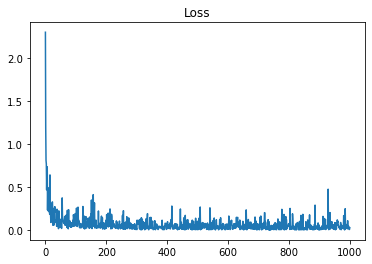

In [ ]:
class CNN_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=5)
        self.dense_layer = nn.Linear(40, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
    
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 1)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)

        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)   
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)

        # third convolutional layer
        z3 = self.conv2(a2)
        # Apply max pooling to convolution.
        z3_pooled = F.max_pool2d(z3, 2) 
        # Apply ReLu to pooled convolution
        a3 = F.relu(z3)

        # fourth convolutional layer
        z4 = self.conv2(a3)
        # Apply max pooling to convolution.
        z4_pooled = F.max_pool2d(z4, 2) 
        # Apply ReLu to pooled convolution
        a4 = F.relu(z4)

        # View as 1-dimensional vector:
        a4 = a4.view(-1, 40) 

        # Dense linear layer
        z5_hidden = self.dense_layer(a4)
        # Apply ReLu to linear layer.
        a5 = F.relu(z5_hidden)
        # Run dropout in training to help prevent overfitting
        a5_dropout = F.dropout(a5, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a5_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn_4 = CNN_4()
loss = train(model=cnn_4, epochs=100, training_data=train_loader, minibatch_steps=100, optimizer=torch.optim.Adam(cnn_4.parameters(), lr=1e-3), loss_function=F.nll_loss)
print("Experiment 4:")
print("Training Accuracy:", classifier(cnn_4, train_loader))
print("Testing Accuracy:", classifier(cnn_4, test_loader))
plt.plot(loss)
plt.title("Loss")
plt.show() 

Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

Answer 2.7:  

#### Note: Epochs and learning_rate is the same for all the experiments

Original: 
* Training Accuracy: 99.43333333333334
* Testing Accuracy: 98.52

Experiment 3: 
* Training Accuracy: 99.11
* Testing Accuracy: 98.45
* Increasing the number of conventional layers to 3, didn't really help improve performance, it actually reduced the training and testing accuracy even if only very slightly.

Experiment 4:
* Training Accuracy: 98.935
* Testing Accuracy: 98.35
* Increasing the number of conventional layers to 4, didn't really help improve performance, it actually reduced the training and testing accuracy even if only slightly.

Seems like increasing the conventional layers doesn't always help in increasing the performance.


Extra Credit 2.8: Use visualize_conv_model_weights to display convolutional network weights. Display for each convolutional layer. Please interpret these images and describe what they are showing.

In [35]:
def visualize_conv_model_weights(model, layer=0):
    """Visualize the weights in the convolutions.
    Args:
      model: Trained convolutional neural net
      layer: which layer to try to visualize. Layer 0 corresponds to conv1, Layer 1 corresponds to conv2
    """
    if layer > 1:
        raise Exception("Convolutional layers are 0 and 1")
    conv_weights = list(model.children())[layer].weight 
    plt.figure(figsize=(20, 17))
    for i, filter in enumerate(conv_weights):
        plt.subplot(8, 8, i+1)
        plt.imshow(filter[0, :, :].detach(), cmap='gray')
        plt.axis('off')
    plt.show()

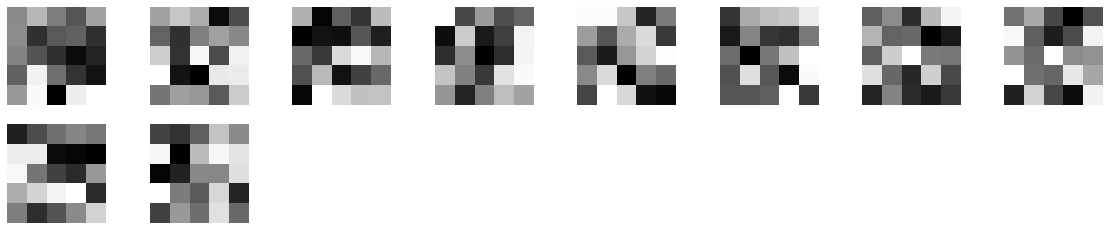

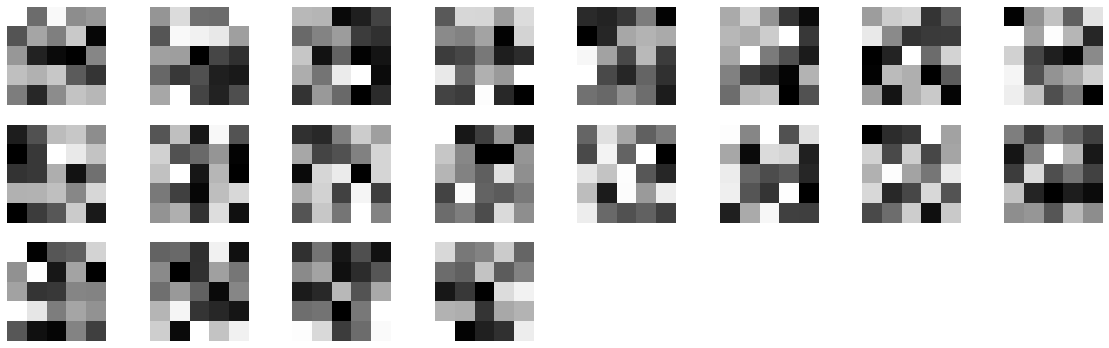

In [36]:
for i in range(2):
    visualize_conv_model_weights(cnn_model, layer=i)

The images show the weights of the model. The darker squares indicate the weight of the model.
* The top images shows  the first convulational layer's the weights for model when using the most defined image. 
* The top image basically shows that the weights of the model are heavy in the darker areas of the image and not in other areas.
* The bottom image is the 2nd convulational layer, shows images of the trained weights for the images for less defined images.
* THe bottom image is basically showing us the weights of the model for the less defined images where the section of the image is darker.